In [ ]:
import ipywidgets as widgets
import sqlalchemy
from sqlalchemy import text
import pandas as pd
from IPython.display import display, clear_output
import os
from sqlalchemy import Column, ForeignKey, Integer, String, Date, PrimaryKeyConstraint, select
from sqlalchemy.orm import declarative_base, relationship, Session

# SQL Injection

*Nell'ambito della sicurezza informatica SQL injection è una tecnica di code injection, usata per attaccare applicazioni che gestiscono dati attraverso database relazionali sfruttando il linguaggio SQL. Il mancato controllo dell'input dell'utente permette di inserire artificiosamente delle stringhe di codice SQL che saranno eseguite dall'applicazione server: grazie a questo meccanismo è possibile far eseguire comandi SQL, anche molto complessi, dall'alterazione dei dati (es. creazione di nuovi utenti) al download completo dei contenuti nel database.*


Vediamo un semplice esempio di SQL Injection.

Supponiamo di avere una tabella

&nbsp;&nbsp;&nbsp;utente (<u>username</u>, password)

In modalità RAW, creiamo un nuovo database con la relativa tabella utente e un paio di utenti.

**Nota:** in questo semplice esempio stiamo inserendo le password in chiaro, questo non è **MAI** da fare. Per proteggere le password bisogna sempre memorizzarle in un formato cifrato.

In [ ]:
# Constrolla se il database esiste, e se esiste lo elimina
if os.path.isfile('sql_injection.db'):
  os.remove('sql_injection.db')

# Crea il database
engine = sqlalchemy.create_engine('sqlite:///sql_injection.db', echo=False)

# Apre la connessione al database
conn = engine.connect()

# Crea la tabella utente con username e password
conn.execute(text("""
    CREATE TABLE utente (
        username VARCHAR(255) PRIMARY KEY,
        password VARCHAR(255) NOT NULL,
        fullname VARCHAR(255) NOT NULL
    )"""))

# Crea una tabella prodotto
conn.execute(text("""
    CREATE TABLE prodotto(
      id INT PRIMARY KEY,
      nome VARCHAR(255)
    );
    """))
# Inserisce all'interno della tabella due utenti
conn.execute(text("""INSERT INTO utente VALUES ('mrossi', '123', 'Mario Rossi'), ('gverdi', '456', 'Giuseppe Verdi');"""))
# Inserisce alcuni prodotti
conn.execute(text("""INSERT INTO prodotto VALUES (1, 'Apple iPhone'), (2, 'Samsung S20'), (3, 'Samsung S24'), (4, 'Huawei P06'), (5, 'Xiaomi 14'), (6, 'Google Pixel 8');"""))
conn.commit()
conn.close()

Ora supponiamo di avere un form HTML in cui gli utenti per fare login inseriscono username e password.

Questi dati vengono inviati dalla pagina web al server che va a verificare con una query i dati dell'utente, quindi compone una query e poi restituisce il risultato alla pagina.

Se la query ritorna i dati dell'utente lascia eseguire il login, altrimenti dice username/password errate.

In [ ]:
# Crea una classe per gestire i login
class Login(object):
  # Memorizza l'ultima query di login eseguita
  login_query = ""

  def __init__(self, engine) -> None:
    self.engine = engine

    # Campo di testo utente
    self.username_txt = widgets.Text(
        value='',
        placeholder='Username',
        description='',
        disabled=False
    )

    # Campo di testo password
    self.password_txt = widgets.Password(
        value='',
        placeholder='Password',
        description='',
        disabled=False
    )

    # Pulsante login
    self.button = widgets.Button(
        description='Login',
        disabled=False,
        button_style='info',
        tooltip='Login'
    )

    # Form
    items = [self.username_txt, self.password_txt, self.button]
    self.form = widgets.GridBox(items, layout=widgets.Layout(grid_template_rows="repeat(3, 40px)"))

    # Associa la funzione di login al pulsante
    self.button.on_click(self.login)

  # Funzione che definisce cosa succede quando viene premuto il pulsante di login
  def login(self, b):
    # Legge il campo username
    username = self.username_txt.value
    # Legge il campo password
    password = self.password_txt.value
    # Compone la query di login
    self.login_query = "SELECT * FROM utente WHERE username = '"+username+"' AND password = '"+password+"'"
    # Si collega al db
    conn = self.engine.connect()
    # Esegue la query e salva il risultato in un dataframe
    result = pd.DataFrame(conn.execute(sqlalchemy.text(self.login_query)))
    conn.close()
    # Pulisce il contenuto della cella e rimostra il form
    clear_output()
    display(self.form)
    # Se la query ha trovato i dati dell'utente, esegue l'autenticazione
    # altrimenti viene fornito un messaggio di errore
    if len(result) > 0:
      print('Autenticato!')
      # Vengono restituite le informazioni (es. per mostrare all'utente un messaggio di benvenuto o altro)
      display(result)
    else:
      print('Dati di login errati!')
    pass

Supponiamo ora che un utente voglia eseguire il login.
Inseriamo username = *mrossi* e password *123*, se proviamo il form tutto funziona correttamente.

In [ ]:
display(Login(engine).form)

Ora supponiamo che arrivi un utente malevolo e provi ad eseguire un attacco di tipo SQL Injection.

Se mettiamo come username *' OR 1=1 --* che cosa succede?

In [ ]:
test = Login(engine)
display(test.form)

Cos'è successo? Proviamo a stampare la query di login

In [ ]:
test.login_query

Questo è un esempio di SQL Injection!

La stringa inserita chiude il parametro *username*, aggiunge l'istruzione *OR 1=1* (quindi sempre vero) e commenta tutto il resto.

Se l'input non viene sanitizzato si possono inserire opportune stringhe al posto dei parametri che possono dare questi risultati!

Altro motivo per cui le password devono essere cifrate, essendo le password in chiaro ora l'utente malevolo può fare il login normalmente sul vostro sistema perché conosce username e password!



Se si guarda la documentazione della funzione [sqlalchemy.text](https://docs.sqlalchemy.org/en/latest/core/sqlelement.html#sqlalchemy.sql.expression.text) viene mostrato il modo corretto per inserire input che provengono dall'utente all'interno di una query.

Ogni libreria ha i suoi metodi per farlo, questo tipo di query in cui si indica la posizione dei parametri tramite placeholder viene denominata **prepared statement**.

In [ ]:
class LoginOk(object):
  def __init__(self, engine) -> None:
    self.engine = engine

    # Campo di testo utente
    self.username_txt = widgets.Text(
        value='',
        placeholder='Username',
        description='',
        disabled=False
    )

    # Campo di testo password
    self.password_txt = widgets.Password(
        value='',
        placeholder='Password',
        description='',
        disabled=False
    )

    # Pulsante login
    self.button = widgets.Button(
        description='Login',
        disabled=False,
        button_style='info',
        tooltip='Login'
    )

    # Griglia
    items = [self.username_txt, self.password_txt, self.button]
    self.form = widgets.GridBox(items, layout=widgets.Layout(grid_template_rows="repeat(3, 40px)"))

    # Associa la funzione di login al pulsante
    self.button.on_click(self.login)

  # Funzione che definisce cosa succede quando viene premuto il pulsante di login
  def login(self, b):
    # Legge il campo username
    username = self.username_txt.value
    # Legge il campo password
    password = self.password_txt.value
    # Crea un prepared statement
    login_prep_query = text("SELECT * FROM utente WHERE username = :user AND password = :passwd")
    # Si collega al db
    conn = self.engine.connect()
    # Esegue la query e salva il risultato in un dataframe
    # I parametri vengono sostituiti con i valori sanificati nel momento in cui si esegue la query
    result = pd.DataFrame(conn.execute(login_prep_query, {"user": username, "passwd": password}))
    conn.close()
    # Pulisce il contenuto della cella e rimostra il form
    clear_output()
    display(self.form)
    # Se la query ha trovato i dati dell'utente, esegue l'autenticazione
    # altrimenti viene fornito un messaggio di errore
    if len(result) > 0:
      print('Autenticato!')
      # Vengono restituite le informazioni (es. per mostrare all'utente un messaggio di benvenuto o altro)
      display(result)
    else:
      print('Dati di login errati!')
    pass

Si può verificare come ora il comportamento sia corretto

In [ ]:
display(LoginOk(engine).form)

Supponiamo ora di avere un campo di ricerca da cui si possono ricercare dei prodotti nel sito web.

La ricerca agisce sul campo *nome* della tabella

&nbsp;&nbsp;&nbsp;prodotto (<u>id</u>, nome)

Possiamo stare tranquilli?

In [ ]:
class SearchBox(object):
  search_query = ""

  def __init__(self, engine) -> None:
    self.engine = engine

    # Campo di testo utente
    self.search_txt = widgets.Text(
        value='',
        placeholder='Nome prodotto',
        description='',
        disabled=False
    )

    # Pulsante login
    self.button = widgets.Button(
        description='Cerca',
        disabled=False,
        button_style='info',
        tooltip='Cerca'
    )

    # Griglia
    items = [self.search_txt, self.button]
    self.form = widgets.GridBox(items, layout=widgets.Layout(grid_template_rows="repeat(2, 40px)"))

    # Associa la funzione di login al pulsante
    self.button.on_click(self.search)

  # Funzione che definisce cosa succede quando viene premuto il pulsante di login
  def search(self, b):
    # Legge il campo di ricerca
    txt = self.search_txt.value.strip()
    conn = self.engine.connect()

    # Pulisce il contenuto della cella e rimostra il form
    clear_output()
    display(self.form)

    if len(txt) == 0:
      print('Inserire un nome prodotto!')
    else:
      self.search_query = "SELECT * FROM prodotto WHERE nome LIKE '%"+txt+"%'"
      # Esegue la query e salva il risultato in un dataframe
      result = pd.DataFrame(conn.execute(sqlalchemy.text(self.search_query)))
      conn.close()
      # Se la query ha trovato i dati dell'utente, esegue l'autenticazione
      # altrimenti viene fornito un messaggio di errore
      if len(result) > 0:
        print('Risultati per la ricerca '+txt)
        # Vengono restituite le informazioni (es. per mostrare all'utente un messaggio di benvenuto o altro)
        display(result)
      else:
        print('Nessun risultato trovato per il prodotto '+txt)
    pass

In [ ]:
search = SearchBox(engine)
display(search.form)

Provate ad inserire nel form precedente la ricerca: *' UNION SELECT username, password FROM utente --*

Che cosa succede?

Stampiamo la query

In [ ]:
search.search_query

Di nuovo, l'input non è stato sanificato e quindi è possibile eseguire query non programmate! Usando l'istruzione UNION siamo riusciti a recuperare dati da una tabella il cuo accesso non era previsto.

## Con ORM il problema non sussiste
(se la libreria che usiamo non ha bug)

Possiamo verificare come con ORM il problema non si possa verificare poiché ogni input viene sanificato dalla libreria.

In [ ]:
# Constrolla se il database esiste, e se esiste lo elimina
if os.path.isfile('sql_injection_orm.db'):
  os.remove('sql_injection_orm.db')

# Crea il database
engine = sqlalchemy.create_engine('sqlite:///sql_injection_orm.db', echo=False)

# Apre la connessioneal database
conn = engine.connect()

# Definisce la tabella utente
Base = declarative_base()
class Utente(Base):
    __tablename__ = "utente"
    username = Column(String, primary_key=True)
    password = Column(String, nullable=False)
    nominativo = Column(String, nullable=False)

    def __repr__(self):
        return f"username={self.username}, password={self.password}, nominativo={self.nominativo}"

# Crea la tabella utente
Base.metadata.create_all(engine)

# Inserisce gli utenti
session = Session(engine)
u1 = Utente(username='mrossi', password='123', nominativo='Mario Rossi')
u2 = Utente(username='gverdi', password='456', nominativo='Giuseppe Verdi')

session.add_all([u1, u2])
session.commit()

Esempio di richiesta corretta: ritorna i dati dell'utente

In [ ]:
username = "mrossi"
password = "123"
query = select(Utente).where(Utente.username == username and Utente.password == password)

for utente in session.execute(query):
    print(utente[0])

Esempio di richiesta malevola (non restituisce nulla)

In [ ]:
username = "' OR 1=1 ;--"
password = ""
query = select(Utente).where(Utente.username == username and Utente.password == password)

for utente in session.execute(query):
    print(utente[0])

<img src=' 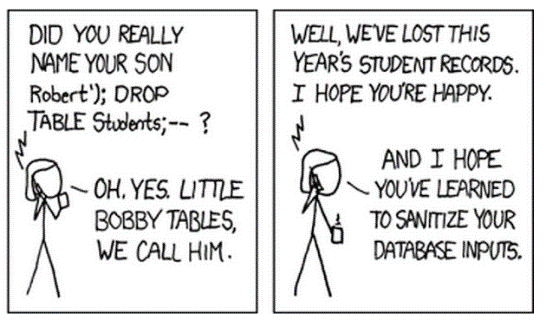' />